# Project Overview

This project will perform an in-depth Exploratory Data Analysis (EDA) on the historical farm production dataset from Canada (1908-1984). I'll analyze crop production, yields, prices, and geographic distributions to uncover insights about agricultural trends during this period.

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv("/kaggle/input/farm-produce-data-80-years/farm_production_dataset.csv")

# a quick glance at the dataset was just imported
df.head()

,REF_DATE,GEO,Type of crop,Average farm price (dollars per tonne),Average yield (kilograms per hectare),Production (metric tonnes),Seeded area (acres),Seeded area (hectares),Total farm value (dollars)
0,1908,AB,Barley,15.00,1585.0,84000.0,129800.0,53000.0,1296
1,1908,AB,Flaxseed,29.00,950.0,1900.0,5900.0,2000.0,56
2,1908,AB,Oats,18.00,1675.0,352000.0,519400.0,210000.0,6316
3,1908,AB,"Rye, all",23.00,1665.0,5000.0,6500.0,3000.0,117
4,1908,AB,Sugar beets,0.55,18100.0,38100.0,5200.0,2100.0,208


## Data Cleaning

Begin by understanding the structure of the dataset and identifying missing values. Clean the column names, check for duplicates, handle missing values, and remove outliers from key numerical columns to ensure high data quality for analysis.


In [86]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10273 entries, 0 to 10272
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   REF_DATE                                10273 non-null  int64  
 1   GEO                                     10273 non-null  object 
 2   Type of crop                            10272 non-null  object 
 3   Average farm price (dollars per tonne)  10243 non-null  float64
 4   Average yield (kilograms per hectare)   10246 non-null  float64
 5   Production (metric tonnes)              10245 non-null  float64
 6   Seeded area (acres)                     9873 non-null   float64
 7   Seeded area (hectares)                  9847 non-null   float64
 8   Total farm value (dollars)              10273 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 722.4+ KB


,REF_DATE,Average farm price (dollars per tonne),Average yield (kilograms per hectare),Production (metric tonnes),Seeded area (acres),Seeded area (hectares),Total farm value (dollars)
count,10273.000000,10243.000000,10246.000000,1.024500e+04,9.873000e+03,9.847000e+03,1.027300e+04
mean,1947.661053,59.633078,3647.442319,1.010887e+06,1.310067e+06,5.316231e+05,5.490084e+04
std,22.204519,90.920549,8068.854966,3.044681e+06,4.881387e+06,1.978043e+06,2.502413e+05
min,1908.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1929.000000,21.000000,1055.000000,8.300000e+03,1.050000e+04,4.350000e+03,3.690000e+02
50%,1948.000000,43.000000,1485.000000,7.195000e+04,8.300000e+04,3.400000e+04,3.006000e+03
75%,1967.000000,76.000000,2363.750000,5.480000e+05,5.831000e+05,2.389000e+05,1.954100e+04
max,1984.000000,6663.300000,460305.000000,1.336790e+08,3.172035e+08,1.283890e+08,4.654194e+06


In [87]:
# the datatypes of each column is pretty tidy, so we don't need to do any changes regarding that.

# Unit Standardization - average farm price and production are measured with tonnes; to make it uniform
df.rename(columns={"Average yield (kilograms per hectare)": "Average yield (tonnes per hectare)"}, inplace=True)
df["Average yield (tonnes per hectare)"] = df["Average yield (tonnes per hectare)"]/1000
df.drop(columns="Seeded area (acres)", inplace=True)

# check if there's any null values
df.isnull().sum()

df.columns = df.columns.str.strip()
df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
df.dropna(subset=["GEO","Type of crop","Average farm price (dollars per tonne)"], inplace=True)

df["Seeded area (hectares)"].fillna(df["Production (metric tonnes)"]/df["Average yield (tonnes per hectare)"], inplace=True)

# verify the values for total farm values
df["Total farm value (dollars)"] = df["Average farm price (dollars per tonne)"] * df["Production (metric tonnes)"]
df.dropna(subset="Seeded area (hectares)", inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10237 entries, 0 to 10272
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   REF_DATE                                10237 non-null  int64  
 1   GEO                                     10237 non-null  object 
 2   Type of crop                            10237 non-null  object 
 3   Average farm price (dollars per tonne)  10237 non-null  float64
 4   Average yield (tonnes per hectare)      10237 non-null  float64
 5   Production (metric tonnes)              10237 non-null  float64
 6   Seeded area (hectares)                  10237 non-null  float64
 7   Total farm value (dollars)              10237 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 719.8+ KB


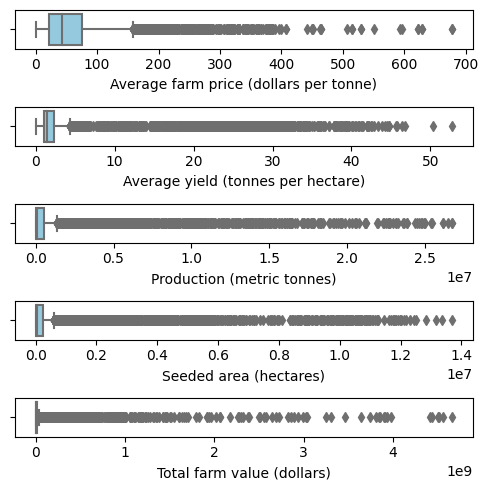

In [88]:
cols = [
    "Average farm price (dollars per tonne)",
    "Average yield (tonnes per hectare)",
    "Production (metric tonnes)",
    "Seeded area (hectares)",
    "Total farm value (dollars)"
]

fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize = (5,5))

for i, col in enumerate(cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color="skyblue")

plt.tight_layout()
plt.show()

## Data Analysis

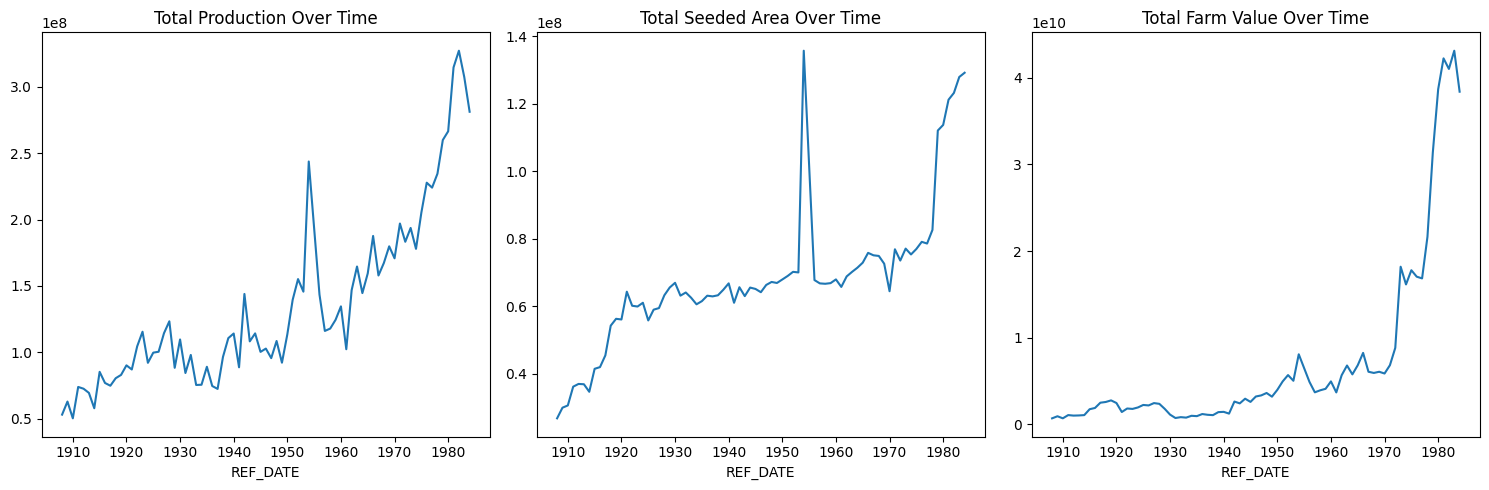

In [89]:
# let's look at the dataset column by column and dig a little deeper.
# first, REF_DATE - how does average yield change over the years?

# Aggregate data by REF_DATE
yearly = df.groupby("REF_DATE").agg({
    "Production (metric tonnes)": 'sum',
    "Seeded area (hectares)": 'sum',
    "Total farm value (dollars)": 'sum'
})

# Plot trends over time
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
yearly["Production (metric tonnes)"].plot(title='Total Production Over Time')
plt.subplot(1, 3, 2)
yearly["Seeded area (hectares)"].plot(title='Total Seeded Area Over Time')
plt.subplot(1, 3, 3)
yearly["Total farm value (dollars)"].plot(title='Total Farm Value Over Time')
plt.tight_layout()
plt.show()

**Seeded Area and Production Trends (1940-1984)**

The line plot reveals a significant surge in farm production beginning in 1970s. However, a closer examination of the period between 1950 and 1960 shows the seeded areas expanded even more rapidly during the decade, with production levels increasing proportionally. This suggests a **strongly positive** correlation between the amount of land cultivated and total agricultural output - a relationship we investigate further in the correlation analysis.

Understanding this shift not only helps explain historical agricultural trends, but also raises compelling questions about what drove the sudden increase in cultivation - such as technological advances, policy changes, or economic shifts. This insight lays the groudwork for building predictive models that estinate future production based on land use.

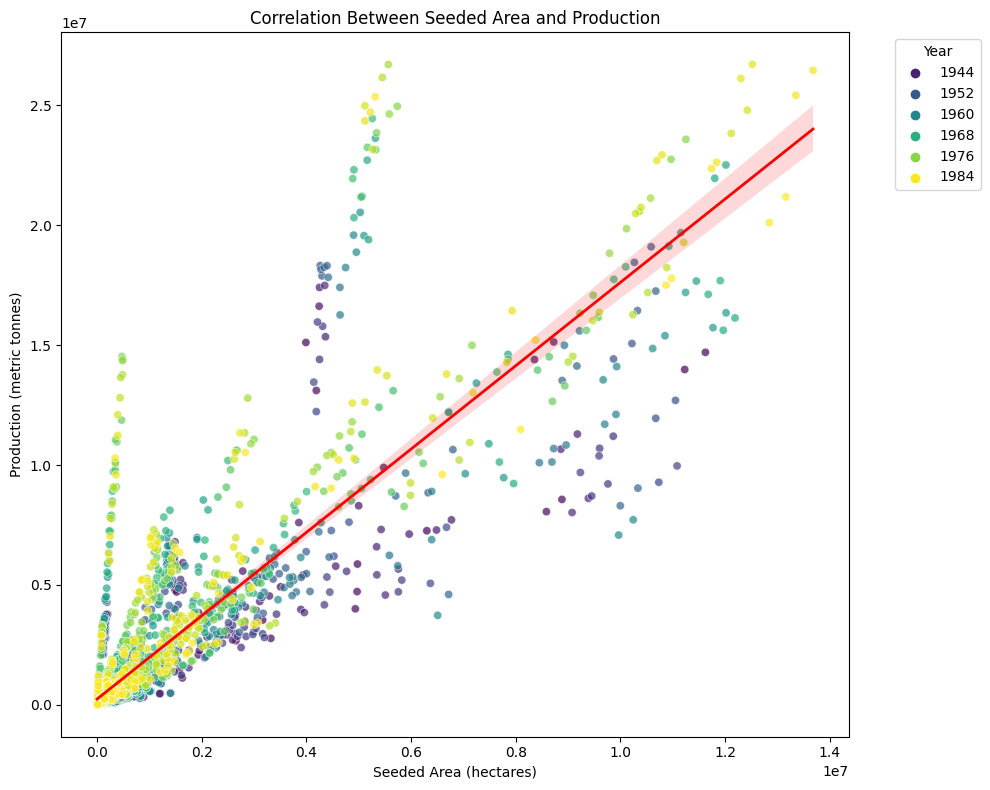

In [90]:
df_corr = df[["REF_DATE","Production (metric tonnes)", "Seeded area (hectares)"]]
df_corr_recent = df[df["REF_DATE"] >= 1940]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    df_corr_recent, 
    x="Seeded area (hectares)", 
    y="Production (metric tonnes)", 
    hue="REF_DATE",
    palette="viridis",
    alpha=0.7
)
sns.regplot(
    data=df_corr_recent,
    x="Seeded area (hectares)",
    y="Production (metric tonnes)",
    scatter=False,
    color="red",
    line_kws={"linewidth": 2}
)
plt.title("Correlation Between Seeded Area and Production")
plt.xlabel("Seeded Area (hectares)")
plt.ylabel("Production (metric tonnes)")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1500x800 with 0 Axes>

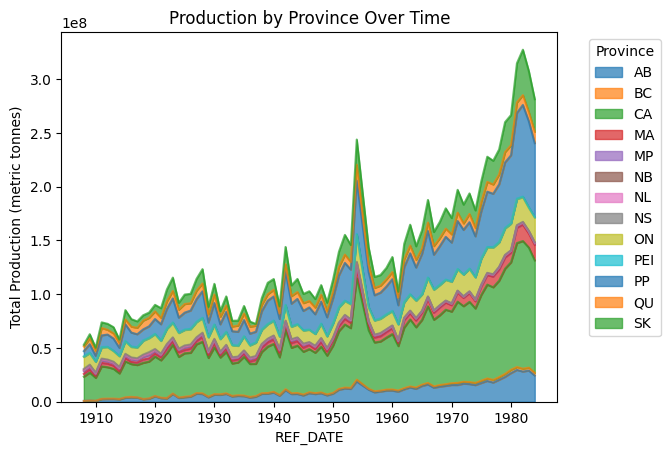

In [91]:
# Next, for GEO column, we can munipulate this column with several analysis
# Which province has the most farm produce?

province_prod = df.groupby(['REF_DATE', 'GEO'])['Production (metric tonnes)'].sum().unstack()
plt.figure(figsize=(15, 8))
province_prod.plot(kind='area', stacked=True, alpha=0.7)
plt.title('Production by Province Over Time')
plt.ylabel('Total Production (metric tonnes)')
plt.legend(title="Province", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

The plot indicates that Alberta (AB), British Columbia (BC) has maintained one of the highest farm production over the years. Combined with the earlier correlation analysis showing a strong relationship between seeded area and production, it is reasonable to assume that Alberta also has the largest seeded area. This could be attributed to their unique geographical advantages, such as vast arable land and favorable climate conditions. Let's now explore whether this assumption holds true.

In [103]:
GEO_area_prod = df.groupby("GEO").agg({
    "Seeded area (hectares)": "sum",
    "Production (metric tonnes)": "sum"
})

print(GEO_area_prod)

     Seeded area (hectares)  Production (metric tonnes)
GEO                                                    
AB             4.170646e+08                7.548790e+08
BC             1.849048e+07                7.860390e+07
CA             1.868495e+09                3.963785e+09
MA             2.352749e+08                3.972966e+08
MP             4.577554e+07                1.385914e+08
NB             2.013861e+07                5.569439e+07
NL             6.600000e+03                2.630000e+04
NS             1.447579e+07                5.170535e+07
ON             2.856948e+08                1.131408e+09
PEI            1.220605e+07                3.367050e+07
PP             1.355671e+09                2.107621e+09
QU             1.659410e+08                5.331671e+08
SK             7.253995e+08                9.764030e+08


* Alberta (AB) ranks 4th in seeded area but still manages a high production output, indicating high land efficiency or favorable growing conditions.

* Saskatchewan (SK), CA (Canada total), and PP (Prairie Provinces) dominate in both seeded area and production, which aligns with their reputation as Canada's agricultural hubs.

* Interestingly, British Columbia (BC), despite high production rankings in earlier plots, has relatively low total seeded area, suggesting intensive farming practices or higher-value crops.

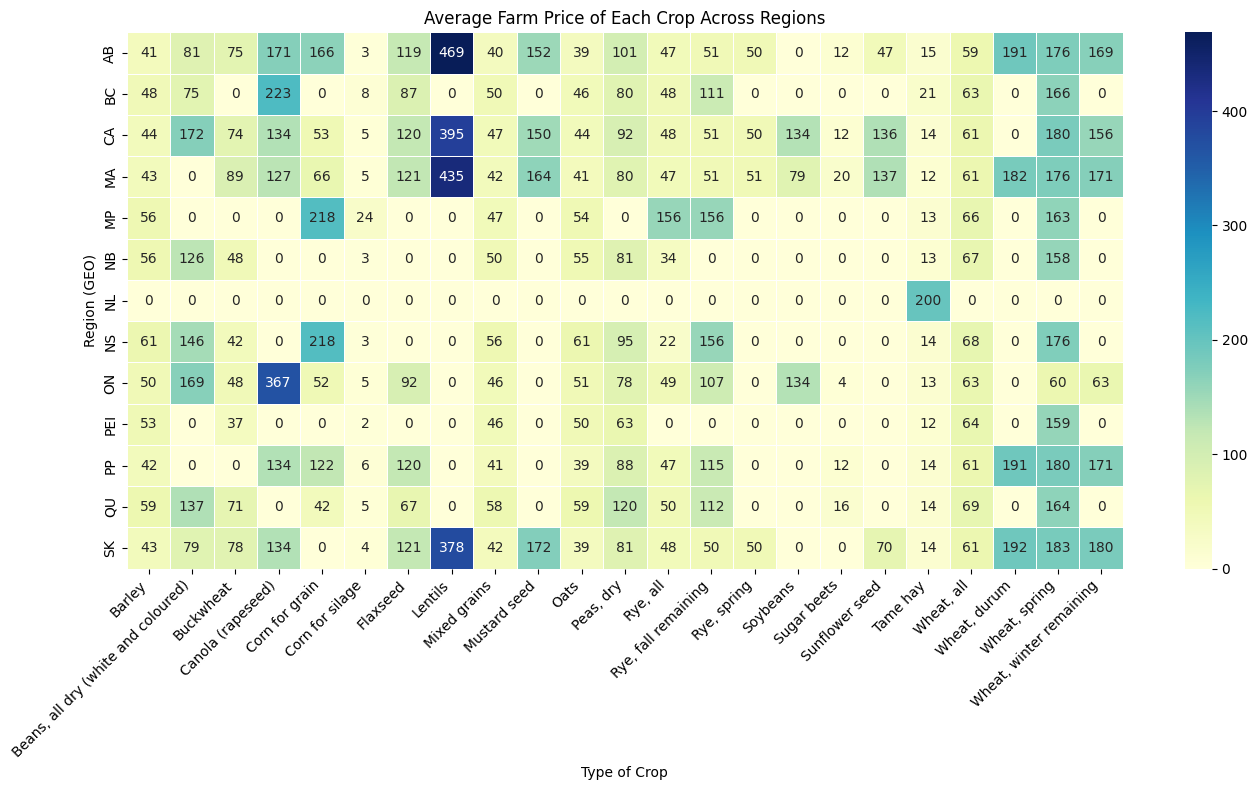

In [94]:
# does one crop has the same average farm price across the country

df_crops_price = df.pivot_table(
    index = "GEO", 
    columns="Type of crop", 
    values= 'Average farm price (dollars per tonne)',
    aggfunc="mean"
)

plt.figure(figsize=(14, 8))
sns.heatmap(df_crops_price.fillna(0), annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Average Farm Price of Each Crop Across Regions")
plt.xlabel("Type of Crop")
plt.ylabel("Region (GEO)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**1. Regional Specialization (Crop Zoning)**
* Some regions, like NL, NB, NS do not produce many types of crops, possibly due to climate, soil conditions, or economic focus. conversely, provinces like SK, AB, MB produce a wide variety of crops.

**2. High-Value Crops by Region**
* lentils prices are highest in AB and MB, suggesting high market value or low supply.
* canola (rapeseed) commands high prices in PEI and MB, indicating regional strength in oilseed farming
* Wheat consistently shows high values across SK, AB, and MB - traditional wheat-producing provinces.

Let's dig a deeper in the types of crop and their yields across the country. Since there are 23 different types of crops, it is more useful to look at the first ten.

Type of crop
Wheat, all           2.096926e+11
Barley               6.303297e+10
Wheat, spring        6.178083e+10
Tame hay             5.957461e+10
Oats                 4.560906e+10
Canola (rapeseed)    2.611715e+10
Corn for grain       1.824826e+10
Flaxseed             1.105034e+10
Mixed grains         9.819510e+09
Corn for silage      7.405171e+09
Name: Total farm value (dollars), dtype: float64


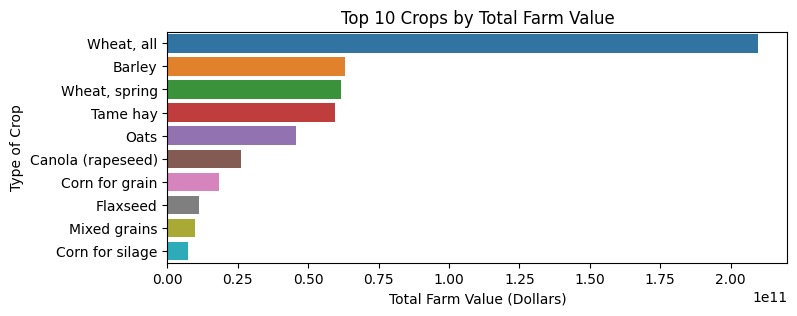

In [95]:
top_10_crops = df.groupby("Type of crop")["Total farm value (dollars)"].sum().sort_values(ascending=False).head(10)

print(top_10_crops)

plt.figure(figsize=(8,3))
sns.barplot(x=top_10_crops.values, y=top_10_crops.index)
plt.xlabel("Total Farm Value (Dollars)")
plt.ylabel("Type of Crop")
plt.title("Top 10 Crops by Total Farm Value")
plt.show()

<Axes: xlabel='REF_DATE', ylabel='GEO'>

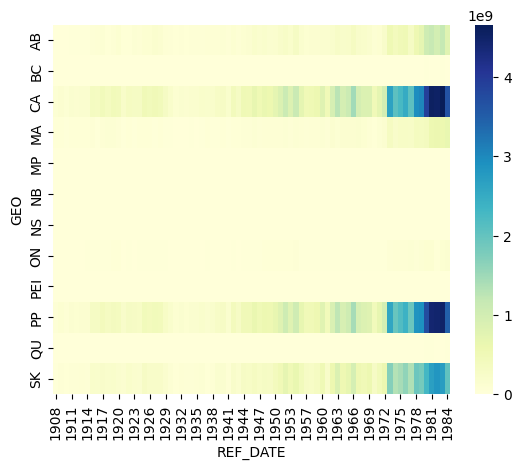

In [96]:
wheat_pivot = df[df["Type of crop"] == "Wheat, all"].pivot_table(
    index="GEO", columns="REF_DATE", values="Total farm value (dollars)", aggfunc="sum"
)
sns.heatmap(wheat_pivot, cmap="YlGnBu")


**Farm Value vs. Production Efficiency**

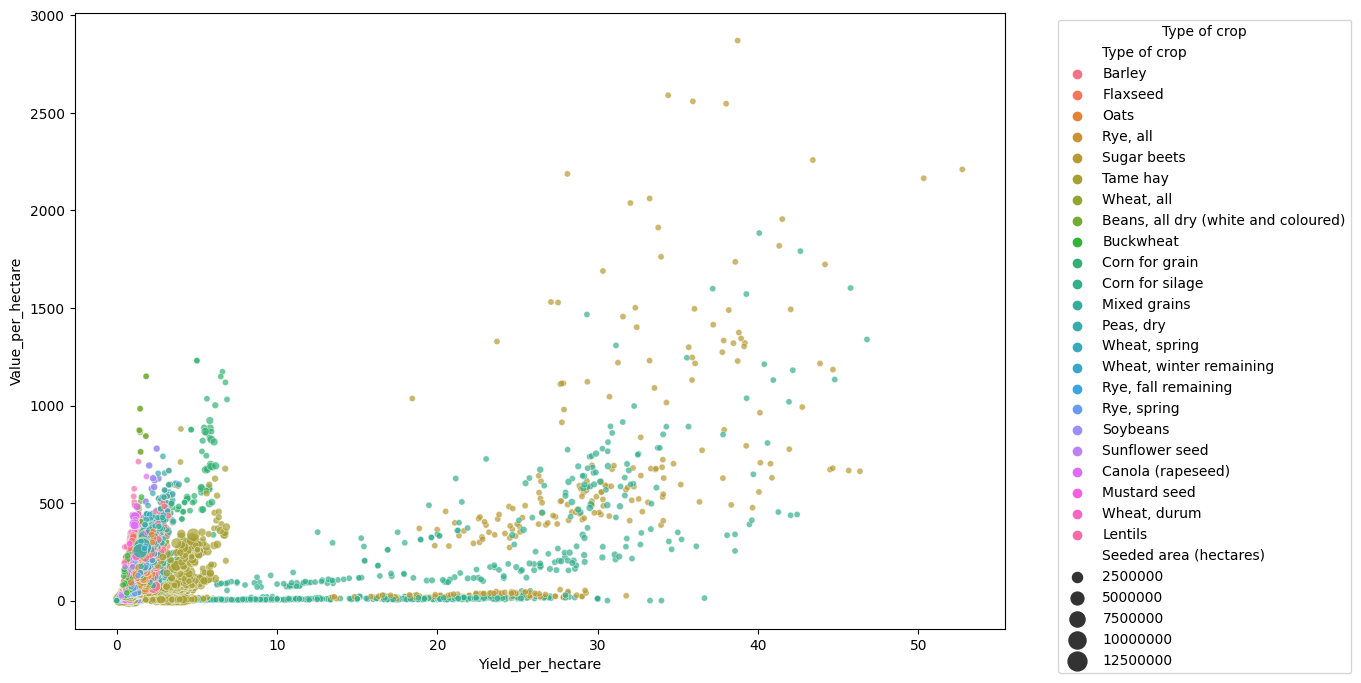

In [97]:
# Calculate yield efficiency (tonnes per hectare) and value per hectare
df['Yield_per_hectare'] = df['Production (metric tonnes)'] / df['Seeded area (hectares)']
df['Value_per_hectare'] = df['Total farm value (dollars)'] / df['Seeded area (hectares)']

# Remove infinite/NA values (from division by zero)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Yield_per_hectare', 'Value_per_hectare'])

plt.figure(figsize=(12, 8))
plt1 = sns.scatterplot(
    data=df,
    x="Yield_per_hectare",
    y="Value_per_hectare",
    hue="Type of crop",
    size= "Seeded area (hectares)", # szie by production scale
    alpha=0.7,
    sizes=(20, 200) # min/max bubble size
)
plt.legend(title="Type of crop", bbox_to_anchor=(1.05, 1), loc='upper left')

In [98]:
# calculate median metrics by crop
crop_stats = df.groupby('Type of crop').agg({
    'Yield_per_hectare': 'median',
    'Value_per_hectare': 'median',
    'Total farm value (dollars)': 'sum'
}).sort_values('Value_per_hectare', ascending=False)

# classify crops into quadrants
crop_stats['Category'] = np.where(
    (crop_stats['Yield_per_hectare'] > crop_stats['Yield_per_hectare'].median()) &
    (crop_stats['Value_per_hectare'] > crop_stats['Value_per_hectare'].median()),
    'High Value, High Yield',
    np.where(
        (crop_stats['Yield_per_hectare'] > crop_stats['Yield_per_hectare'].median()),
        'Low Value, High Yield',
        np.where(
            (crop_stats['Value_per_hectare'] > crop_stats['Value_per_hectare'].median()),
            'High Value, Low Yield',
            'Low Value, Low Yield'
        )
    )
)

print(crop_stats[['Category', 'Value_per_hectare', 'Yield_per_hectare']].head(10))

                                                   Category  \
Type of crop                                                  
Lentils                               High Value, Low Yield   
Wheat, durum                         High Value, High Yield   
Wheat, spring                        High Value, High Yield   
Corn for grain                       High Value, High Yield   
Soybeans                             High Value, High Yield   
Wheat, winter remaining              High Value, High Yield   
Beans, all dry (white and coloured)   High Value, Low Yield   
Canola (rapeseed)                     High Value, Low Yield   
Peas, dry                             High Value, Low Yield   
Mustard seed                          High Value, Low Yield   

                                     Value_per_hectare  Yield_per_hectare  
Type of crop                                                               
Lentils                                     418.847534           1.099858  
Wheat, durum   

## Business Implications
The findings could help:
1. Understand historical agricultural trends
2. Identify factors driving production increases
3. Inform predictive models for future production based on land use
4. Guide regional agricultural planning and investment decisions

This project provides a comprehensive foundation for further analysis of Canadian agricultural productivity patterns over the 20th century.